# Nipype-FSL fMRI Analysis
## First-level, second-level and third-level GLM

####
**Author:** Monika Doerig

**Date:** 21 Oct 2023

### Citation and Resources:

#### Workflows this work is based on
__Original paper and code:__

- Chen Y, Hopp FR, Malik M, Wang PT, Woodman K, Youk S and Weber R (2022) Reproducing FSL's fMRI data analysis via Nipype: Relevance, challenges, and solutions. Front. Neuroimaging 1:953215. doi: [10.3389/fnimg.2022.953215](https://www.frontiersin.org/articles/10.3389/fnimg.2022.953215/full)

- [Original code on OSF](https://osf.io/prg53/?view_only=9d7974834a484cdb972bcc3989589b78)

#### Tools included in this workflow
__FSL:__
- M. Jenkinson, C.F. Beckmann, T.E. Behrens, M.W. Woolrich, S.M. Smith. FSL. [NeuroImage, 62:782-90, 2012](https://doi.org/10.1016/j.neuroimage.2011.09.015)

__Nipype:__
-  Esteban, O., Markiewicz, C. J., Burns, C., Goncalves, M., Jarecka, D., Ziegler, E., Berleant, S., Ellis, D. G., Pinsard, B., Madison, C., Waskom, M., Notter, M. P., Clark, D., Manhães-Savio, A., Clark, D., Jordan, K., Dayan, M., Halchenko, Y. O., Loney, F., … Ghosh, S. (2025). nipy/nipype: 1.8.6 (1.8.6). Zenodo [https://doi.org/10.5281/zenodo.15054147](https://doi.org/10.5281/zenodo.15054147)


#### Dataset
__Flanker Dataset from OpenNeuro:__
- Kelly AMC and Uddin LQ and Biswal BB and Castellanos FX and Milham MP (2018). Flanker task (event-related). [OpenNeuro Dataset ds000102](https://openneuro.org/datasets/ds000102/versions/00001)
- Kelly, A.M., Uddin, L.Q., Biswal, B.B., Castellanos, F.X., Milham, M.P. (2008). Competition between functional brain networks mediates behavioral variability. Neuroimage, 39(1):527-377-37

# First-level GLM using Nipype FSL

In this notebook, we recreate the first-level GLM and the first level GLM of FSL GUI using nipype code. For each nipype node, we list the corresponding fsl command from the log file. The dataset we use is a Flanker task, which can be downloaded [here](https://openneuro.org/datasets/ds000102/versions/00001).

We also borrow some help from this [document](https://nipype.readthedocs.io/en/latest/users/examples/fmri_fsl.html). 


In [1]:
#load fsl module
import module
await module.purge(force=True)
await module.load('fsl/6.0.4') #Original pipeline: FSL 6.0.4, nipype 1.6.1.
await module.list()

['fsl/6.0.4']

In [2]:
import os
os.environ["FSLOUTPUTTYPE"]="NIFTI_GZ"

## Preparation
Import all the relevant libraries needed for the preprocessing stage.

In [3]:
%%capture
!pip install --upgrade numpy==1.26.4 pandas==2.3.3 nibabel==5.3.3 nilearn==0.13.1

In [4]:
from __future__ import print_function
from __future__ import division
from builtins import str
from builtins import range

from glob import glob

from nipype import Function
from nipype.interfaces import fsl, utility as util, io as nio
import nipype.pipeline.engine as pe  # pypeline engine
import nipype.algorithms.modelgen as model  # model generation
import nipype.algorithms.rapidart as ra  # artifact detection
import matplotlib.pyplot as plt

import nilearn
from nilearn.image import math_img
from nilearn import surface, plotting, datasets
import nibabel as nib

In [5]:
# check output type and fsl version
print(fsl.Info.output_type())
print(fsl.Info.version())

NIFTI_GZ
6.0.4:ddd0a010


#### Set up data paths

In [6]:
# Input: Set the BIDS path
data_dir_first = os.path.join(os.getcwd(), 'ds000102')
# Output: Set path where nipype will store stepwise results
exp_dir_first = os.path.join(os.getcwd(), 'output_level1')

# Input: Set path of first level outputs
data_dir_second = os.path.join(os.getcwd(), 'output_level1/level1_results/')
# Output: Set path where nipype will store stepwise results
exp_dir_second = os.path.join(os.getcwd(), 'output_level2/')

# Input: Set path of second level outputs
data_dir_third = os.path.join(os.getcwd(), 'output_level2/level2_results/')
# Output: Set path where nipype will store stepwise results
exp_dir_third = os.path.join(os.getcwd(), 'output_level3/')

PATTERN = "sub-0*"

In [7]:
# Use Nilearn's MNI152 template to keep the notebook self-contained and portable
mni = datasets.load_mni152_template(resolution=2)

# Corresponding brain mask
mask = datasets.load_mni152_brain_mask(resolution=2)

# Brain-extracted MNI template
mni_img = math_img("img1 * img2", img1=mni, img2=mask)

# Write to disk (portable, CI-safe)
mni_brain = os.path.abspath("MNI152_T1_2mm_brain_nilearn.nii.gz")
nib.save(mni_img, mni_brain)


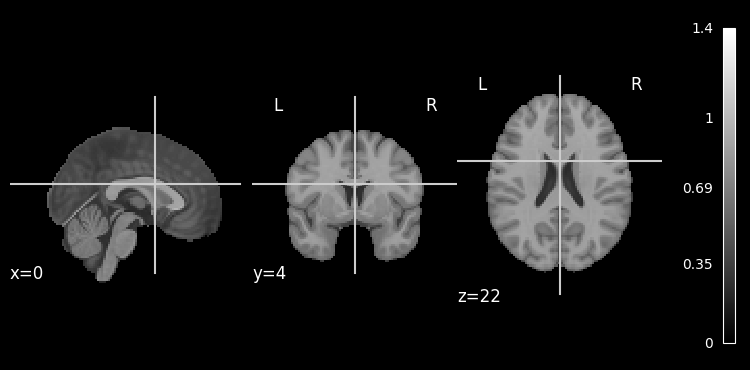

In [8]:
plotting.plot_anat(mni_brain)

In [9]:
!datalad install https://github.com/OpenNeuroDatasets/ds000102.git
!cd ds000102 && datalad get $PATTERN

Cloning:   0%|                             | 0.00/2.00 [00:00<?, ? candidates/s]
Enumerating: 0.00 Objects [00:00, ? Objects/s]
                                              
Counting:   0%|                               | 0.00/27.0 [00:00<?, ? Objects/s]
                                                                                
Compressing:   0%|                            | 0.00/23.0 [00:00<?, ? Objects/s]
                                                                                
Receiving:   0%|                             | 0.00/2.15k [00:00<?, ? Objects/s]
                                                                                
Resolving:   0%|                                | 0.00/537 [00:00<?, ? Deltas/s]
[INFO   ] Remote origin not usable by git-annex; setting annex-ignore           
[INFO   ] https://github.com/OpenNeuroDatasets/ds000102.git/config download failed: Not Found 
[INFO   ] access to 1 dataset sibling s3-PRIVATE not auto-enabled, enable with:
| 

#### Start the workflow

In [10]:
wf_first = pe.Workflow(name='level1', base_dir=exp_dir_first)
wf_first.config["execution"]["crashfile_format"] = "txt"

The following two nodes (`infosource` & `dg`) together define all inputs required for the preprocessing workflow

In [11]:
# get subject_id list - we only do 9 subjects here so the notebook runs in a reasonable time
subj_list = [x.split('-')[-1] for x in glob(data_dir_first+"/"+PATTERN)]
subj_list.sort()
print(subj_list)

['01', '02', '03', '04', '05', '06', '07', '08', '09']


In [12]:
infosource_first = pe.Node(util.IdentityInterface(fields=["subject_id"]),
                  name="infosource")
infosource_first.iterables = [("subject_id", subj_list)]

In [13]:
dg_first = pe.Node(
    interface=nio.DataGrabber(
        infields=["subject_id","run_id"], outfields=["struct", "func", "events"]
    ),
    name="dg_first"
)

# Specify run_ids and return a sorted filelist to ensure we match files to correct runs/tasks
dg_first.inputs.run_id = [1,2]
dg_first.inputs.sort_filelist = True
dg_first.inputs.template = "*"
dg_first.inputs.base_directory = data_dir_first

# Define arguments fill the wildcards in the below paths 
dg_first.inputs.template_args = dict(
    struct=[["subject_id","subject_id"]],
    func=[["subject_id","subject_id","run_id"]],
    events=[["subject_id","subject_id","run_id"]]
)

dg_first.inputs.field_template = dict(
    struct = "sub-%s/anat/sub-%s_T1w.nii.gz",
    func="sub-%s/func/sub-%s_task-flanker_run-%d_bold.nii.gz",
    events="sub-%s/func/sub-%s_task-flanker_run-%d_events.tsv", 
)

wf_first.connect([
        (infosource_first, dg_first, [("subject_id", "subject_id")])
])

## Initialisation

Convert functional images to float representation. Since there can be more than one functional run we use a MapNode to convert each run.

**Corresponding FSL command:**

```
/usr/local/fsl/bin/fslmaths ../sub-11/func/sub-11_task-flanker_run-1_bold prefiltered_func_data -odt float
```

In [14]:
img2float = pe.MapNode(
    interface=fsl.ImageMaths(out_data_type='float', op_string='', suffix='_dtype'),
    name='img2float',
    iterfield=['in_file'])
wf_first.connect(dg_first, 'func', img2float, 'in_file')

Extract the middle volume of the first run as the reference

(Head movement, motion-correction)

**Corresponding FSL command:**

```
/usr/local/fsl/bin/fslroi prefiltered_func_data example_func 73 1
```

In [15]:
# Extract one roi
extract_ref = pe.MapNode(interface=fsl.ExtractROI(t_size=1), 
                         name='extractref',
                         iterfield=['in_file'])
wf_first.connect(img2float, 'out_file', extract_ref, 'in_file')

# Define a function to return the 1 based index of the middle volume
def getmiddlevolume(func):
    from nibabel import load
    funcfile = func
    if isinstance(func, list):
        funcfile = func[0]
    _, _, _, timepoints = load(funcfile).shape
    return int(timepoints/2) 

wf_first.connect(img2float, ('out_file', getmiddlevolume), extract_ref, 't_min')

## Preprocessing

### Motion Correction

Realign the functional runs to the middle volume of each run

**Corresponding FSL command:**

```
/usr/local/fsl/bin/mcflirt -in prefiltered_func_data -out prefiltered_func_data_mcf -mats -plots -reffile example_func -rmsrel -rmsabs -spline_final
```

```
save_mats (a boolean) – Save transformation matrices. Maps to a command-line argument: -mats.
save_plots (a boolean) – Save transformation parameters. Maps to a command-line argument: -plots.
save_rms (a boolean) – Save rms displacement parameters. Maps to a command-line argument: -rmsabs -rmsrel.
Interpolation (‘spline’ or ‘nn’ or ‘sinc’) – Interpolation method for transformation. Maps to a command-line argument: -%s_final.
```

In [16]:
motion_correct = pe.MapNode(
    interface=fsl.MCFLIRT(save_mats=True, save_plots=True, save_rms=True, interpolation='spline'),
    name='realign',
    iterfield=['in_file','ref_file'])
wf_first.connect(img2float, 'out_file', motion_correct, 'in_file')
wf_first.connect(extract_ref, 'roi_file', motion_correct, 'ref_file')

Plot the estimated motion parameters

**Corresponding FSL command:**

```
/usr/local/fsl/bin/fsl_tsplot -i prefiltered_func_data_mcf.par -t 'MCFLIRT estimated rotations (radians)' -u 1 --start=1 --finish=3 -a x,y,z -w 640 -h 144 -o rot.png 

/usr/local/fsl/bin/fsl_tsplot -i prefiltered_func_data_mcf.par -t 'MCFLIRT estimated translations (mm)' -u 1 --start=4 --finish=6 -a x,y,z -w 640 -h 144 -o trans.png 

/usr/local/fsl/bin/fsl_tsplot -i prefiltered_func_data_mcf_abs.rms,prefiltered_func_data_mcf_rel.rms -t 'MCFLIRT estimated mean displacement (mm)' -u 1 -w 640 -h 144 -a absolute,relative -o disp.png
```

In [17]:
plot_motion = pe.MapNode(
    interface=fsl.PlotMotionParams(in_source='fsl'),
    name='plot_motion',
    iterfield=['in_file'])
plot_motion.iterables = ('plot_type', ['rotations', 'translations','displacement'])
wf_first.connect(motion_correct, 'par_file', plot_motion, 'in_file')

### Functionally Masking

```
Passing the reference volume to the FSL command-line tool bet to generate a binary brain mask and afterward multiplying the processed functional time series by the brain mask using the fslmaths command to produce a skull-stripped time series.
```

See [Ciric et al.(2018)](https://www.nature.com/articles/s41596-018-0065-y)

Extract the mean volume of each functional run

**Corresponding FSL command:**

```
/usr/local/fsl/bin/fslmaths prefiltered_func_data_mcf -Tmean mean_func
```

In [18]:
meanfunc = pe.MapNode(
    interface=fsl.ImageMaths(op_string='-Tmean', suffix='_mean'),
    name='meanfunc',
    iterfield=['in_file'])
wf_first.connect(motion_correct, 'out_file', meanfunc, 'in_file')

Strip the skull from the mean functional to generate a mask

**Corresponding FSL command:**

```
/usr/local/fsl/bin/bet2 mean_func mask -f 0.3 -n -m; /usr/local/fsl/bin/immv mask_mask mask
```

In [19]:
meanfuncmask = pe.MapNode(
    interface=fsl.BET(mask=True, no_output=True, frac=0.3),
    name='meanfuncmask',
    iterfield=['in_file'])
wf_first.connect(meanfunc, 'out_file', meanfuncmask, 'in_file')

Mask the functional data with the extracted mask

**Corresponding FSL command:**

```
/usr/local/fsl/bin/fslmaths prefiltered_func_data_mcf -mas mask prefiltered_func_data_bet
```

In [20]:
maskfunc = pe.MapNode(
    interface=fsl.ImageMaths(suffix='_bet', op_string='-mas'),
    name='maskfunc',
    iterfield=['in_file','in_file2'])
wf_first.connect(motion_correct, 'out_file', maskfunc, 'in_file')
wf_first.connect(meanfuncmask, 'mask_file', maskfunc, 'in_file2')

### Grand Mean Scaling

Determine the 2nd and 98th percentile intensities 

**Corresponding FSL command:**

```
/usr/local/fsl/bin/fslstats prefiltered_func_data_bet -p 2 -p 98
0.000000 873.492249 (these numbers are for subject-11 run-01)
```

More info [here](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Fslutils)

In [21]:
getthresh = pe.MapNode(
    interface=fsl.ImageStats(op_string='-p 2 -p 98'),
    name='getthreshold',
    iterfield=['in_file'])
wf_first.connect(maskfunc, 'out_file', getthresh, 'in_file')

Threshold the first TR of the functional data at 10% of the 98th percentile

**Corresponding FSL command:**

```
/usr/local/fsl/bin/fslmaths prefiltered_func_data_bet -thr 87.3492249 -Tmin -bin mask -odt char
```

In [22]:
threshold = pe.MapNode(
    interface=fsl.ImageMaths(out_data_type='char', suffix='_thresh'),
    name='threshold',
    iterfield=['in_file','op_string'])
wf_first.connect(maskfunc, 'out_file', threshold, 'in_file')

# Define a function to get 10% of the intensity
def getthreshop(thresh):
    return ['-thr %.10f -Tmin -bin' % (0.1 * th[1]) for th in thresh]

wf_first.connect(getthresh, ('out_stat', getthreshop), threshold, 'op_string')

Determine the median value of the TRs using the mask

**Corresponding FSL command:**

```
/usr/local/fsl/bin/fslstats prefiltered_func_data_mcf -k mask -p 50
728.800232 (this number is for subject-11 run-01)
```

In [23]:
medianval = pe.MapNode(
    interface=fsl.ImageStats(op_string='-k %s -p 50'),
    name='medianval',
    iterfield=['in_file','mask_file'])
wf_first.connect(motion_correct, 'out_file', medianval, 'in_file')
wf_first.connect(threshold, 'out_file', medianval, 'mask_file')

Dilate the mask

The brain mask is "dilated" slightly before being used. Because it is normally important that masking be liberal (ie that there be little risk of cutting out valid brain voxels) 

**Corresponding FSL command:**

```
/usr/local/fsl/bin/fslmaths mask -dilF mask
```

The output of `dilatemask` (i.e., `/srv/scratch/yc/fsl/hw2/level1/_subject_id_26/dilatemask/mapflow/_dilatemask0/sub-26_task-flanker_run-1_bold_dtype_mcf_bet_thresh_dil.nii.gz`) is equivalent to `mask.nii.gz` from FSL GUI.

In [24]:
dilatemask = pe.MapNode(
    interface=fsl.ImageMaths(suffix='_dil', op_string='-dilF'),
    name='dilatemask',
    iterfield=['in_file'])
wf_first.connect(threshold, 'out_file', dilatemask, 'in_file')

Mask the motion corrected functional runs with the dilated mask

**Corresponding FSL command:**

```
/usr/local/fsl/bin/fslmaths prefiltered_func_data_mcf -mas mask prefiltered_func_data_thresh
```

In [25]:
maskfunc2 = pe.MapNode(
    interface=fsl.ImageMaths(suffix='_thresh', op_string='-mas'),
    iterfield=['in_file','in_file2'],
    name='maskfunc2')
wf_first.connect(motion_correct, 'out_file', maskfunc2, 'in_file')
wf_first.connect(dilatemask, 'out_file', maskfunc2, 'in_file2')

### SUSAN Noise Reduction

Determine the mean image from each TR

**Corresponding FSL command:**

```
/usr/local/fsl/bin/fslmaths prefiltered_func_data_thresh -Tmean mean_func
```

In [26]:
meanfunc2 = pe.MapNode(
    interface=fsl.ImageMaths(op_string='-Tmean', suffix='_mean'),
    name='meanfunc2',
    iterfield=['in_file'])
wf_first.connect(maskfunc2, 'out_file', meanfunc2, 'in_file')

Merge the median values with the mean functional images into a coupled list

The output of this `merge` node will go into `susan` as `usans`,

In [27]:
# why here use node not mapnode?
mergenode = pe.Node(interface=util.Merge(2, axis='hstack'), 
                       name='merge')
wf_first.connect(meanfunc2, 'out_file', mergenode, 'in1')
wf_first.connect(medianval, 'out_stat', mergenode, 'in2')

Smooth each run using SUSAN with the brightness threshold set to 75% of the median value for each run and a mask constituting the mean functional

```
Usage: susan <input> <bt> <dt> <dim> <use_median> <n_usans> [<usan1> <bt1> [<usan2> <bt2>]] <output>
<bt> is brightness threshold and should be greater than noise level and less than contrast of edges to be preserved.
<dt> is spatial size (sigma, i.e., half-width) of smoothing, in mm.
<dim> is dimensionality (2 or 3), depending on whether smoothing is to be within-plane (2) or fully 3D (3).
<use_median> determines whether to use a local median filter in the cases where single-point noise is detected (0 or 1).
<n_usans> determines whether the smoothing area (USAN) is to be found from secondary images (0, 1 or 2).
A negative value for any brightness threshold will auto-set the threshold at 10% of the robust range
```

**Corresponding FSL command:**

```
/usr/local/fsl/bin/susan prefiltered_func_data_thresh 546.600174 2.12314225053 3 1 1 mean_func 546.600174 prefiltered_func_data_smooth
```

**Note:**

for `<bt>`, Nipype uses a different algorithm to calculate it -> `float(fwhm) / np.sqrt(8 * np.log(2))`. Therefore, to get `2.12314225053`, fwhm should be `4.9996179300001655` instead of `5`

In [28]:
fwhm_thr = 4.9996179300001655

smooth = pe.MapNode(
    interface=fsl.SUSAN(fwhm = fwhm_thr),
    name='smooth',
    iterfield=['in_file', 'brightness_threshold', 'usans'])

# Define a function to get the brightness threshold for SUSAN
def getbtthresh(medianvals):
    return [0.75 * val for val in medianvals]

def getusans(x):
    return [[tuple([val[0], 0.75 * val[1]])] for val in x]

wf_first.connect(maskfunc2, 'out_file', smooth, 'in_file')
wf_first.connect(medianval, ('out_stat', getbtthresh), smooth,
                'brightness_threshold')
wf_first.connect(mergenode, ('out', getusans), smooth, 'usans')

Mask the smoothed data with the dilated mask


**Corresponding FSL command:**

```
/usr/local/fsl/bin/fslmaths prefiltered_func_data_smooth -mas mask prefiltered_func_data_smooth
```

In [29]:
maskfunc3 = pe.MapNode(
    interface=fsl.ImageMaths(op_string='-mas'),
    name='maskfunc3',
    iterfield=['in_file','in_file2'])
wf_first.connect(smooth, 'smoothed_file', maskfunc3, 'in_file')
wf_first.connect(dilatemask, 'out_file', maskfunc3, 'in_file2')

Scale each volume of the TR so that the median value of the TR is set to 10000

**Corresponding FSL command:**

```
/usr/local/fsl/bin/fslmaths prefiltered_func_data_smooth -mul 13.7211811425 prefiltered_func_data_intnorm 
(this number is for subject-11 run-01)
```

In [30]:
intnorm = pe.MapNode(
    interface=fsl.ImageMaths(suffix='_intnorm'),
    iterfield=['in_file', 'op_string'],
    name='intnorm')
wf_first.connect(maskfunc3, 'out_file', intnorm, 'in_file')

# Define a function to get the scaling factor for intensity normalization
def getinormscale(medianvals):
    return ['-mul %.10f' % (10000. / val) for val in medianvals]

wf_first.connect(medianval, ('out_stat', getinormscale), intnorm, 'op_string')

### Temporal Filtering

Perform temporal highpass filtering on the data

**Corresponding FSL command:**

```
/usr/local/fsl/bin/fslmaths prefiltered_func_data_intnorm -Tmean tempMean
/usr/local/fsl/bin/fslmaths prefiltered_func_data_intnorm -bptf 25.0 -1 -add tempMean prefiltered_func_data_tempfilt
```

The output of `highpass` (i.e., `sub-11_task-flanker_run-1_bold_dtype_mcf_mask_smooth_mask_intnorm_tempfilt.nii.gz`) is equivalent to `filtered_func_data.nii.gz` from FSL GUI.

In [31]:
# Generate a mean functional image from the scaled data and this mean func will be used in performing temporal highpass filtering
meanfunc3 = pe.MapNode(
    interface=fsl.ImageMaths(op_string='-Tmean'),
    iterfield=['in_file'],
    name='meanfunc3')
wf_first.connect(intnorm, 'out_file', meanfunc3, 'in_file')

In [32]:
# Perform temporal highpass filtering on the data
hpcutoff = 100
TR = 2.  # ensure float

highpass = pe.MapNode(
    interface=fsl.ImageMaths(suffix='_tempfilt'),
    name='highpass',
    iterfield=['in_file','op_string'])

# 25 = (hpcutoff / 2*TR) not (hpcutoff / TR)
def gethpstring(tempMean):
    return ['-bptf 25 -1 -add %s' % (tm) for tm in tempMean]

wf_first.connect(intnorm, 'out_file', highpass, 'in_file')
wf_first.connect(meanfunc3, ('out_file',gethpstring), highpass, 'op_string')

Generate a mean functional image from the functional run

**Corresponding FSL command:**

```
/usr/local/fsl/bin/fslmaths prefiltered_func_data_tempfilt filtered_func_data
/usr/local/fsl/bin/fslmaths filtered_func_data -Tmean mean_func
```

In [33]:
meanfunc4 = pe.MapNode(
    interface=fsl.ImageMaths(op_string='-Tmean', suffix='_mean'),
    iterfield=['in_file'],
    name='meanfunc4')
wf_first.connect(highpass, 'out_file', meanfunc4, 'in_file')

## First-Level GLM

### Get events

In [34]:
def subjinfo(events):
    from nipype.interfaces.base import Bunch
    import pandas as pd
    import numpy as np

    subject_info = []

    ev = pd.read_csv(events, sep="\t")
    ev = ev[ev['correctness']=='correct']
    ev['new_type'] = ev['trial_type'].apply(lambda x: str(x).split('_')[0])

    run_info = Bunch(onsets=[], 
                     durations=[])

    run_info.set(conditions=[g[0] for g in ev.groupby("new_type")])

    for group in ev.groupby("new_type"):
        run_info.onsets.append(group[1].onset.tolist())
        run_info.durations.append(group[1].duration.tolist())
    subject_info.append(run_info)

    return subject_info

get_sub_info = pe.MapNode(
    Function(
        function=subjinfo, input_names=["events"], output_names="subject_info"
    ),
    name="get_sub_info", iterfield=["events"]
)

# Connect to workflow
wf_first.connect(dg_first, 'events', get_sub_info, 'events')

### Set-up contrasts

In [35]:
condition_names = ["congruent", "incongruent"]

# Activation Contrasts (similar to https://direct.mit.edu/jocn/article/23/10/3162/5327/Is-Morality-Unified-Evidence-that-Distinct-Neural)
## From FEAT: "The correct way to tell whether two conditions are significantly different is to run a differential contrast like [1 -1] between them"
cont01 = ("congruent", "T", condition_names,  [1, 0])
cont02 = ("incongruent", "T", condition_names, [0, 1])
cont03 = ("congruent-incongruent", "T", condition_names, [1, -1])
cont04 = ("incongruent-congruent", "T", condition_names,  [-1, 1])

contrast_list = [
    cont01,
    cont02,
    cont03,
    cont04
]

In [36]:
TR = 2.0  # Repetition Time
hpcutoff = 100  # highpass filter cutoff in seconds! 

modelspec = pe.MapNode(interface=model.SpecifyModel(), name="modelspec", iterfield=["subject_info","functional_runs"])
modelspec.inputs.input_units = "secs"
modelspec.inputs.high_pass_filter_cutoff = hpcutoff
modelspec.inputs.time_repetition = TR

wf_first.connect(get_sub_info, 'subject_info', modelspec,'subject_info')
wf_first.connect(highpass, 'out_file',modelspec,'functional_runs')

In [37]:
level1design = pe.MapNode(interface=fsl.Level1Design(), name="level1design", iterfield=["session_info"])
level1design.inputs.interscan_interval = TR
# Set HRF bases functions
level1design.inputs.bases = {"gamma": {"derivs": False, 'gammasigma':3, 'gammadelay':6}}
level1design.inputs.model_serial_correlations = True
level1design.inputs.contrasts = contrast_list

wf_first.connect(modelspec,'session_info', level1design, 'session_info')

In [38]:
modelgen = pe.MapNode(
    interface=fsl.FEATModel(),
    name='modelgen',
    iterfield=['fsf_file', 'ev_files'])

wf_first.connect([(level1design, modelgen, [('fsf_files', 'fsf_file'), 
                                    ('ev_files','ev_files')])])

**Corresponding fsl command:**

```
/usr/local/fsl/bin/film_gls --in=filtered_func_data --rn=stats --pd=design.mat --thr=1000.0 --sa --ms=5 --con=design.con  

--thr: threshold
--sa: smooth_autocorr
--ms: mask_size
```

In [39]:
level1estimate = pe.MapNode(
    interface=fsl.FILMGLS(smooth_autocorr=True, mask_size=5, threshold=1000),
    name='level1estimate',
    iterfield=['design_file', 'in_file', 'tcon_file'])

wf_first.connect([
    (highpass,level1estimate,[('out_file','in_file')]),
    (modelgen,level1estimate,[('design_file','design_file'),
                               ('con_file','tcon_file')])
])

no need to use `ContrastMgr`, 

```
In interface mode this file assumes that all the required inputs are in the same location. This has deprecated for FSL versions 5.0.7+ as the necessary corrections file is no longer generated by FILMGLS.
```
see this [link](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.model.html#contrastmgr)

## Registration

According to [FSL UserGuide](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FEAT/UserGuide#Higher-Level_FEAT_Output), the different sessions need to be **registered** to each other before any multi-session or multi-subject analyses can be carried out. Registration inside FEAT uses `FLIRT` and is a two-statge process:

1. An example FMRI low resolution image is registered to an example high resolution image (normally the same subject's T1-weighted structural). The transformation for this is saved into the FEAT directory. Then the high res image is registered to a standard image (normally a T1-weighted image in standard space, such as the MNI 152 average image).
2. The two transformations are combined into a third, which will take the low resolution FMRI images (and the statistic images derived from the first-level analyses) straight into standard space, when applied later, during group analysis.

#### Step 1
**Corresponding FSL command:**

```
/usr/local/fsl/bin/flirt -in example_func -ref standard -out example_func2standard -omat example_func2standard.mat -cost corratio -dof 12 -searchrx -90 90 -searchry -90 90 -searchrz -90 90 -interp trilinear 

/usr/local/fsl/bin/convert_xfm -inverse -omat standard2example_func.mat example_func2standard.mat
```

In [40]:
flt = pe.MapNode(interface=fsl.FLIRT(cost='corratio', dof=12,
                                    searchr_x = [-90,90],
                                    searchr_y = [-90,90],
                                    searchr_z = [-90,90],
                                    interp = 'trilinear'), 
               name='example_func2standard',
               iterfield=['in_file'])

flt.inputs.reference = mni_brain #fsl.Info.standard_image('MNI152_T1_2mm_brain.nii.gz')
wf_first.connect(extract_ref, 'roi_file', flt, 'in_file')

convertxfm = pe.MapNode(interface=fsl.ConvertXFM(invert_xfm = True), 
                         name='convertxfm',
                         iterfield=['in_file'])
wf_first.connect(flt, 'out_matrix_file', convertxfm, 'in_file')

#### Step 2

**Corresponding fsl command:**

```
/usr/local/fsl/bin/flirt -ref reg/standard -in stats/cope1 -out /srv/scratch/yc/fsl/nipype_fsl_comp/gui/sub-01/run1.feat/frgrot_chksugax -applyxfm -init reg/example_func2standard.mat -interp trilinear -datatype float
```

In [41]:
def warp_files(copes, varcopes, masks, mat, reference):
    # need to reimport here, otherwise errors come out
    import nipype.interfaces.fsl as fsl 
    
    out_copes = []
    out_varcopes = []
    out_masks = []
    
    # register mask, same function, different parameters
    warp_mask = fsl.FLIRT(apply_xfm = True, 
                     interp = 'nearestneighbour')
    warp_mask.inputs.reference = reference #fsl.Info.standard_image('MNI152_T1_2mm_brain.nii.gz')
    warp_mask.inputs.in_matrix_file = mat
    warp_mask.inputs.output_type = "NIFTI_GZ"
    warp_mask.inputs.in_file = masks
    res_mask = warp_mask.run()
    out_masks.append(str(res_mask.outputs.out_file))
    
    # register copes & varcopes using same function, different parameters
    warp = fsl.FLIRT(apply_xfm = True, 
                     interp = 'trilinear')
    warp.inputs.reference = reference #fsl.Info.standard_image('MNI152_T1_2mm_brain.nii.gz')
    warp.inputs.in_matrix_file = mat
    warp.inputs.output_type = "NIFTI_GZ"
    
    # register copes
    for cope in copes:
        warp.inputs.in_file = cope
        res = warp.run()
        out_copes.append(str(res.outputs.out_file))
        
     # register varcopes
    for varcope in varcopes:
        warp.inputs.in_file = varcope
        res = warp.run()
        out_varcopes.append(str(res.outputs.out_file))

    return out_copes, out_varcopes, out_masks

In [42]:
warpfunc = pe.MapNode(util.Function(input_names=['copes', 'varcopes', 'masks', 'mat', 'reference'],
                                    output_names=['out_copes', 'out_varcopes', 'out_masks'],
                                    function=warp_files),
                      iterfield=['copes', 'varcopes', 'masks','mat'],
                      name='warpfunc')
warpfunc.inputs.reference = mni_brain

wf_first.connect(level1estimate, 'copes', warpfunc, 'copes')
wf_first.connect(level1estimate, 'varcopes', warpfunc, 'varcopes')
wf_first.connect(dilatemask, 'out_file', warpfunc, 'masks')
wf_first.connect(flt, 'out_matrix_file', warpfunc, 'mat')

In [43]:
# save all results into single/separate folder for further analysis use
datasink_first = pe.Node(nio.DataSink(), name='sinker')
datasink_first.inputs.base_directory=os.path.join(exp_dir_first, "level1_results")

wf_first.connect(infosource_first, 'subject_id', datasink_first, 'container')
wf_first.connect([(level1estimate, datasink_first, [('results_dir', 'results_dir')])])
wf_first.connect([(warpfunc, datasink_first, [('out_copes', 'reg_copes')])])
wf_first.connect([(warpfunc, datasink_first, [('out_varcopes', 'reg_varcopes')])])
wf_first.connect([(warpfunc, datasink_first, [('out_masks', 'reg_masks')])])

260216-00:55:54,440 nipype.workflow INFO:
	 Generated workflow graph: /home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/output_level1/level1/graph.png (graph2use=colored, simple_form=True).


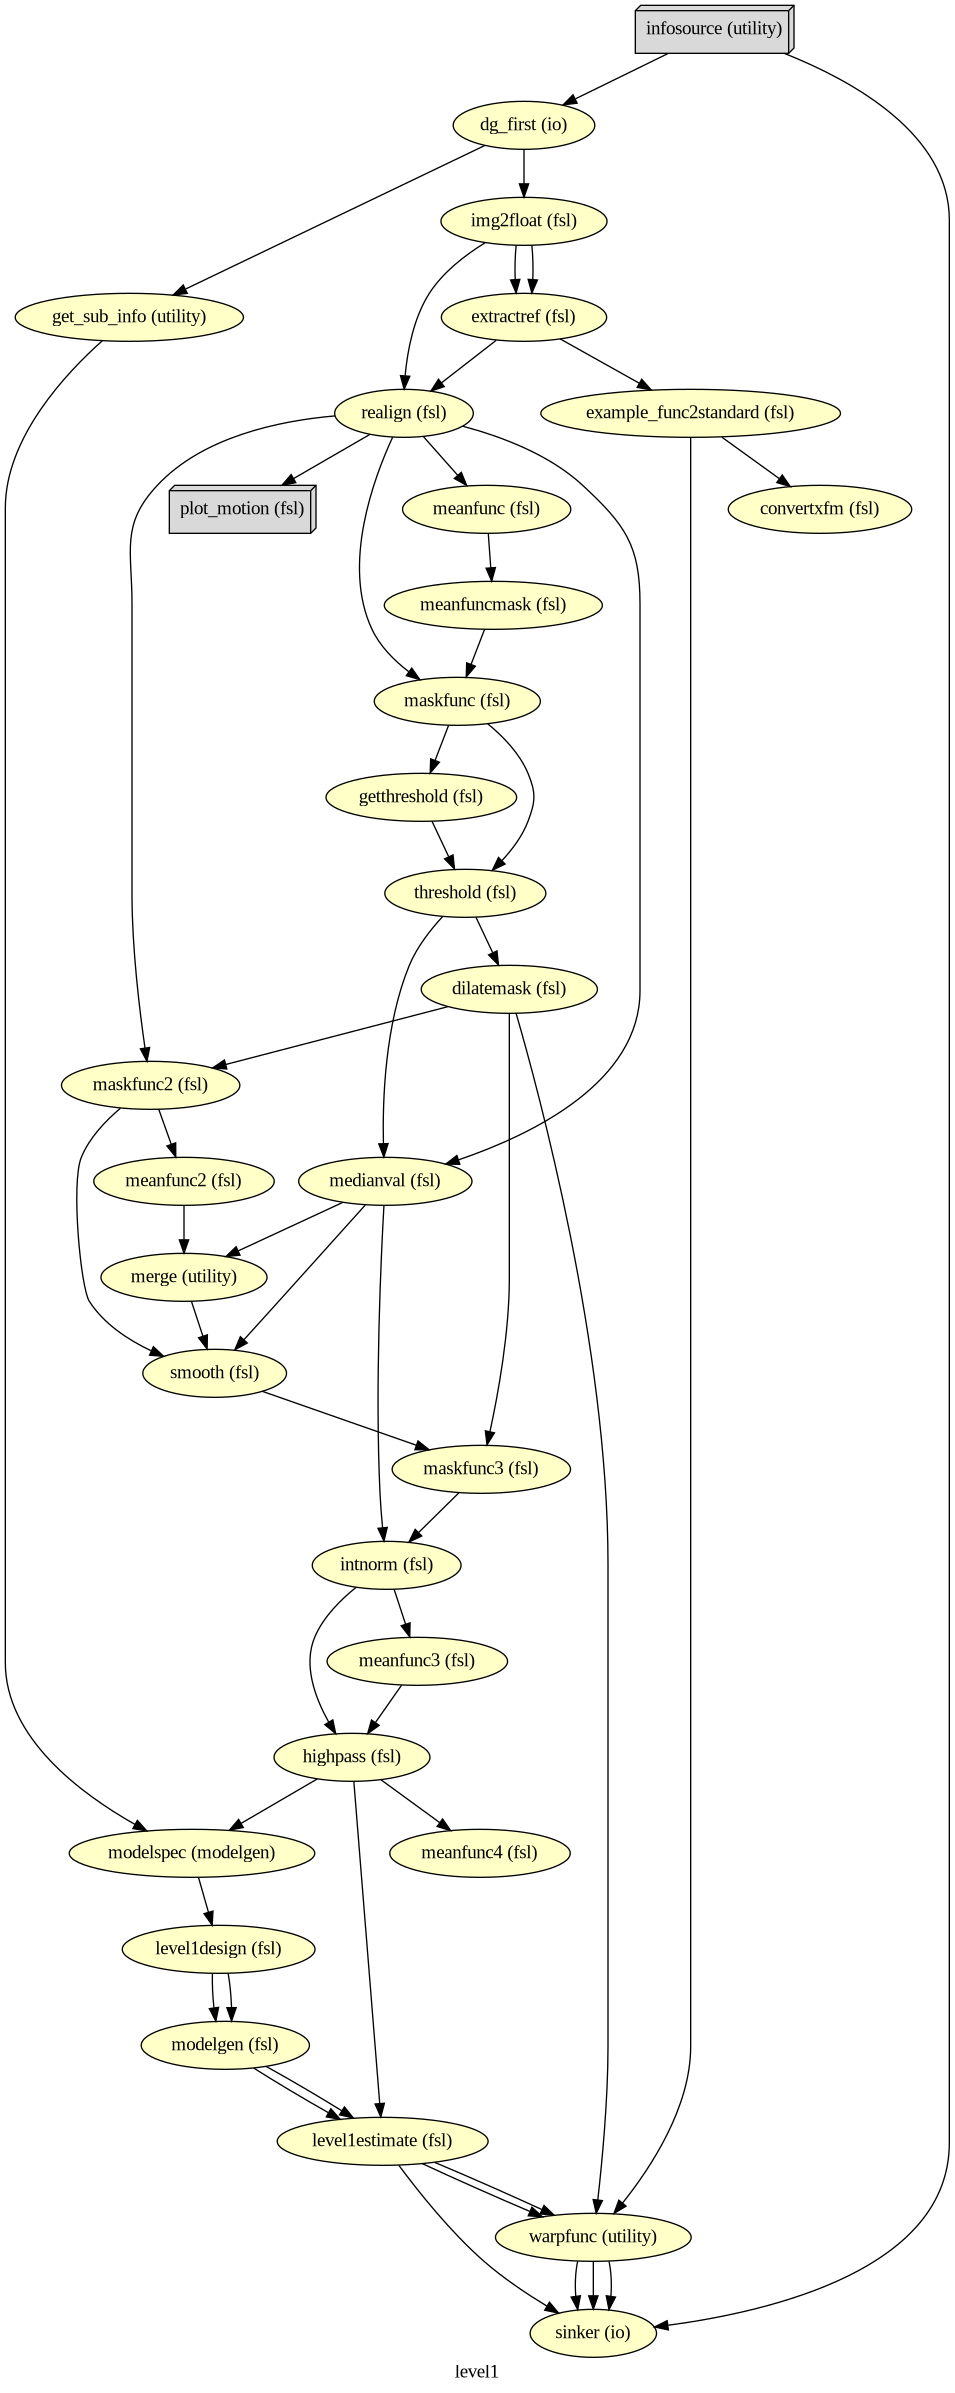

In [44]:
# Create 1st-level analysis output graph
wf_first.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=os.path.join(wf_first.base_dir, wf_first.name, 'graph.png'))

In [45]:
import logging
logging.getLogger('nipype.workflow').setLevel(0) #set to 1 to get nipype output
# Run Workflow
wf_first.run(plugin="MultiProc", plugin_args={"n_procs": 8})

## The first-level GLM

Here we randomly choose the four copes from subject-09 run-1

In [46]:
fsaverage = nilearn.datasets.fetch_surf_fsaverage()
plotting.show() 

In [47]:
nipype_cope1 = './output_level1/level1_results/09/results_dir/_subject_id_09/_level1estimate0/results/cope1.nii.gz'
nipype_cope2 = './output_level1/level1_results/09/results_dir/_subject_id_09/_level1estimate0/results/cope2.nii.gz'
nipype_cope3 = './output_level1/level1_results/09/results_dir/_subject_id_09/_level1estimate0/results/cope3.nii.gz'
nipype_cope4 = './output_level1/level1_results/09/results_dir/_subject_id_09/_level1estimate0/results/cope4.nii.gz'

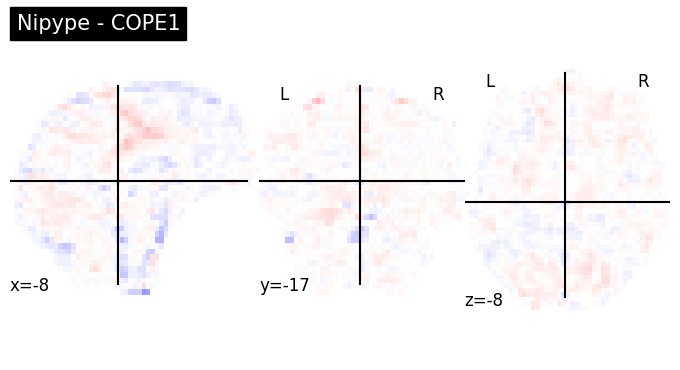

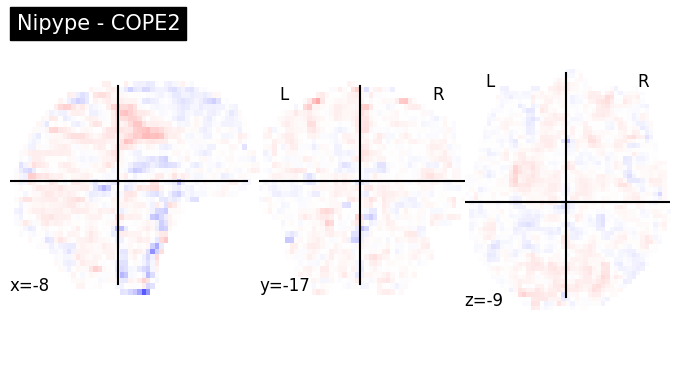

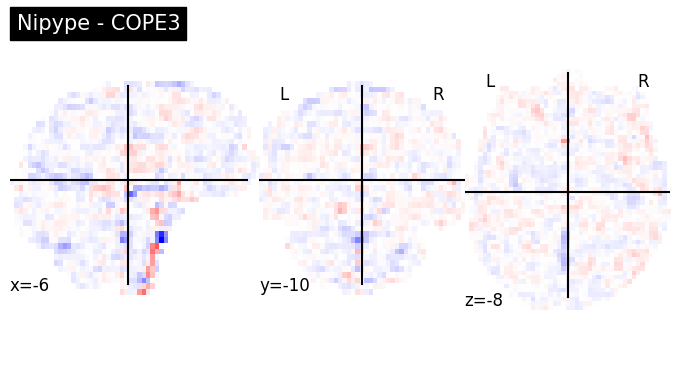

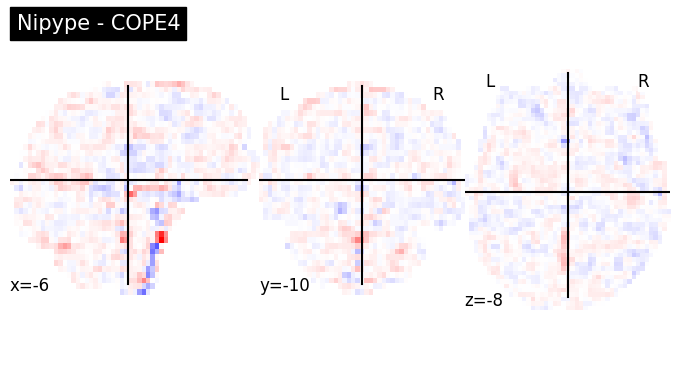

In [48]:
plotting.plot_stat_map(nipype_cope1, bg_img=nipype_cope1, title = 'Nipype - COPE1', cmap = 'bwr', colorbar = False)
plt.show()
plotting.plot_stat_map(nipype_cope2, bg_img=nipype_cope1, title = 'Nipype - COPE2', cmap = 'bwr', colorbar = False)
plt.show()
plotting.plot_stat_map(nipype_cope3, bg_img=nipype_cope1, title = 'Nipype - COPE3', cmap = 'bwr', colorbar = False)
plt.show()
plotting.plot_stat_map(nipype_cope4, bg_img=nipype_cope1, title = 'Nipype - COPE4', cmap = 'bwr', colorbar = False)
plt.show()

# Second level GLM using Nipype FSL

In [49]:
wf_second = pe.Workflow(name='level2', base_dir=exp_dir_second)
wf_second.config["execution"]["crashfile_format"] = "txt"

The following two nodes (`infosource` & `dg`) together define all inputs required for the preprocessing workflow

In [50]:
# we want to group the outcome by contrast not subject
contr_list = [1,2,3,4]
infosource_second = pe.Node(util.IdentityInterface(fields=["contr_id"]),
                  name="infosource_second")
infosource_second.iterables = [("contr_id", contr_list)]

In [51]:
# here we use SelectFiles, instead of DataGrabber, because the former is more flexible with formatting syntax
templates_second = {
    "reg_copes":"*/reg_copes/*/*/cope{contr_id}_flirt.nii.gz",
    "reg_varcopes":"*/reg_varcopes/*/*/varcope{contr_id}_flirt.nii.gz",
    "reg_masks":"*/reg_masks/*/*/*.nii.gz"
}

dg_second = pe.Node(interface=nio.SelectFiles(templates_second),
             name="selectfiles_second")
dg_second.inputs.base_directory = data_dir_second

wf_second.connect([
        (infosource_second, dg_second, [("contr_id", "contr_id")])
])

## Second-level GLM
Combining results from multiple runs of one subject into one

### Higher-level input files preparation
#### Step 1: Merge registered copes & varcopes & masks

**Corresponding FSL command:**
```
/usr/local/fsl/bin/fslmerge -t mask (masks from all 52 inputs)
/usr/local/fsl/bin/fslmerge -t cope (copes from all 52 inputs)
/usr/local/fsl/bin/fslmerge -t varcop (varcopes from all 52 inputs)
```

In [52]:
copemerge_second = pe.Node(
    interface=fsl.Merge(dimension='t'),
    iterfield=['in_files'],
    name="copemerge_second")

varcopemerge_second = pe.Node(
    interface=fsl.Merge(dimension='t'),
    iterfield=['in_files'],
    name="varcopemerge_second")

maskmerge_second = pe.Node(
    interface=fsl.Merge(dimension='t'),
    iterfield=['in_files'],
    name="maskmerge_second")


def sort_copes(files):
    numelements = len(files[0])
    outfiles = []
    for i in range(numelements):
        outfiles.insert(i, [])
        for j, elements in enumerate(files):
            outfiles[i].append(elements[i])
    return outfiles

wf_second.connect(dg_second, 'reg_varcopes', varcopemerge_second, 'in_files')
wf_second.connect(dg_second, 'reg_copes', copemerge_second, 'in_files')
wf_second.connect(dg_second, 'reg_masks', maskmerge_second, 'in_files')

#### Step 2: Making mask

In FSL, there are many commands about `maskunique`, which is unless for the second level. We can ignore it.

**Corresponding FSL command:**
```
/usr/local/fsl/bin/fslmaths mask -Tmin mask
```

In [53]:
minmask_second = pe.Node(
    interface=fsl.ImageMaths(op_string='-Tmin'),
    iterfield=['in_file'],
    name='minmask_second')

wf_second.connect(maskmerge_second, 'merged_file', minmask_second, 'in_file')

#### Step 3: Masking copes & varcopes

**Corresponding FSL command:**

we have four contrasts so the following commands repeat four times

```
/usr/local/fsl/bin/fslmaths cope1 -mas mask cope1
/usr/local/fsl/bin/fslmaths varcope1 -mas mask varcope1
```

In [54]:
maskcope_second = pe.Node(
    interface=fsl.ImageMaths(op_string='-mas'),
    iterfield=['in_file', 'in_file2'],
    name='maskcope_second')

maskvarcope_second = pe.Node(
    interface=fsl.ImageMaths(op_string='-mas'),
    iterfield=['in_file', 'in_file2'],
    name='maskvarcope_second')

wf_second.connect(copemerge_second, 'merged_file', maskcope_second, 'in_file')
wf_second.connect(minmask_second, 'out_file', maskcope_second, 'in_file2')
wf_second.connect(varcopemerge_second, 'merged_file', maskvarcope_second, 'in_file')
wf_second.connect(minmask_second, 'out_file', maskvarcope_second, 'in_file2')

### Set up second-level contrasts and fixed-effects

In [55]:
def get_contrasts_l2(in_files):
    import numpy as np
    import glob
    total = len(in_files)
    print(in_files)
    print(total)
    n_sub = 9  
    ev_list = ['ev'+str(x) for x in range(1,n_sub+1)]
    weight_mtx = np.zeros((n_sub,n_sub))
    weight_mtx = weight_mtx.astype(np.float64)
    np.fill_diagonal(weight_mtx,1.)
    #contr = ['','T',ev_list,list(weight_mtx[0])] --> original paper
    contr = np.array(['','T', ev_list, list(weight_mtx[0])], dtype=object) #adaptation so the construction of the array works
    contr_lst = np.tile(contr, (n_sub,n_sub))
    contr_lst = [tuple(x) for x in contr_lst] 
    for i in range(n_sub):
        # Instead of trying to change the tuple, create a new tuple with the changed value.
        contr_lst[i] = (contr_lst[i][0], contr_lst[i][1], contr_lst[i][2], list(weight_mtx[i]))

    reg_dict = {k:None for k in ev_list}
    for k in reg_dict.keys():
        start_lst = [0.0] * total
        idx = ev_list.index(k)
        start_idx = idx*2
        end_idx = idx*2 + 1
        start_lst[start_idx] = 1.
        start_lst[end_idx] = 1.
        reg_dict[k] = start_lst    
    return contr_lst, reg_dict

contrastgen_l2 = pe.Node(util.Function(input_names=['in_files'],
                                    output_names=['contr_lst', 'reg_dict'],
                                    function=get_contrasts_l2),
                      iterfield=['in_files'],
                      name='contrastgen_l2')

wf_second.connect(dg_second,'reg_copes', contrastgen_l2, 'in_files')

Nipype recommends using [L2Model](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.model.html#l2model), which only works for the single subject. It takes the number of runs (copes at the first level) as input and does estimations for subject one by one.
Instead, we use [MultipleRegressDesign](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.model.html#multipleregressdesign). As it's name indicates, this one can deal with multiple predictors (subjects) at the same time.

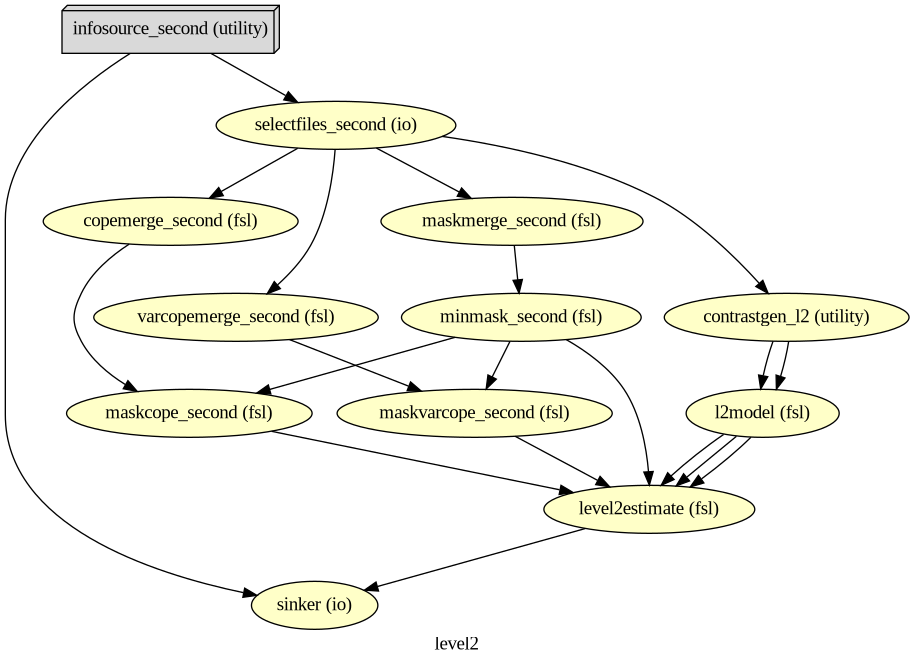

In [56]:
level2model = pe.Node(interface=fsl.MultipleRegressDesign(),
                      name='l2model')

wf_second.connect([(contrastgen_l2, level2model, [('contr_lst','contrasts'),
                                        ('reg_dict','regressors')])])

level2estimate = pe.Node(
    interface=fsl.FLAMEO(run_mode='fe'),
    name="level2estimate",
    iterfield=['cope_file', 'var_cope_file'])

wf_second.connect([
    (maskcope_second, level2estimate, [('out_file', 'cope_file')]),
    (maskvarcope_second, level2estimate, [('out_file', 'var_cope_file')]),
    (minmask_second, level2estimate, [('out_file', 'mask_file')]),
    (level2model, level2estimate, [('design_mat', 'design_file'),
                                   ('design_con', 't_con_file'), 
                                   ('design_grp', 'cov_split_file')]),
])

datasink_second = pe.Node(nio.DataSink(), name='sinker')
datasink_second.inputs.base_directory=os.path.join(exp_dir_second, "level2_results")

int2string = lambda x: 'contrast_'+str(x)
    
wf_second.connect(infosource_second, ('contr_id',int2string), datasink_second, 'container')
wf_second.connect([(level2estimate, datasink_second, [('stats_dir', 'stats_dir')])])

# Create 1st-level analysis output graph
wf_second.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=os.path.join(wf_second.base_dir, wf_second.name, 'graph.png'))

In [57]:
# Run Workflow
wf_second.run(plugin="MultiProc", plugin_args={"n_procs": 8})

['/home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/output_level1/level1_results/01/reg_copes/_subject_id_01/_warpfunc0/cope1_flirt.nii.gz', '/home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/output_level1/level1_results/01/reg_copes/_subject_id_01/_warpfunc1/cope1_flirt.nii.gz', '/home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/output_level1/level1_results/02/reg_copes/_subject_id_02/_warpfunc0/cope1_flirt.nii.gz', '/home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/output_level1/level1_results/02/reg_copes/_subject_id_02/_warpfunc1/cope1_flirt.nii.gz', '/home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/output_level1/level1_results/03/reg_copes/_subject_id_03/_warpfunc0/cope1_flirt.nii.gz', '/home/jovyan/Git_repositories/neurodeskedu/books/examples/functional_imaging/output_level1/level1_results/03/reg_copes/_subject_id_03/_warpfunc1/cope1_flirt.nii.gz

## The second-level GLM

Here we choose the four copes from subject-01

### Regapply

This happens before the second-level GLM, all results from the first level are needed to be registered into the standard space

In [58]:
nipype_cope1 = './output_level1/level1_results/01/reg_copes/_subject_id_01/_warpfunc1/cope1_flirt.nii.gz'
nipype_cope2 = './output_level1/level1_results/01/reg_copes/_subject_id_01/_warpfunc1/cope2_flirt.nii.gz'
nipype_cope3 = './output_level1/level1_results/01/reg_copes/_subject_id_01/_warpfunc1/cope3_flirt.nii.gz'
nipype_cope4 = './output_level1/level1_results/01/reg_copes/_subject_id_01/_warpfunc1/cope4_flirt.nii.gz'

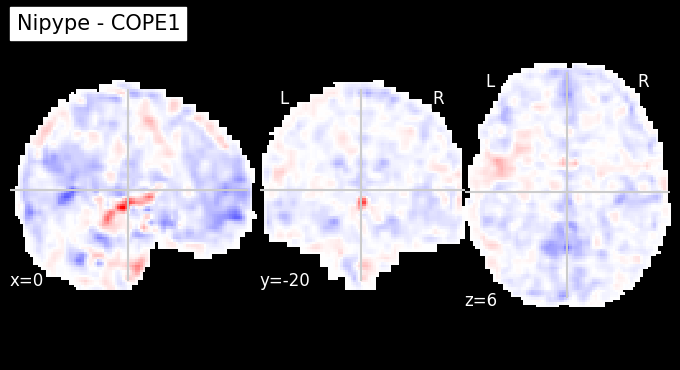

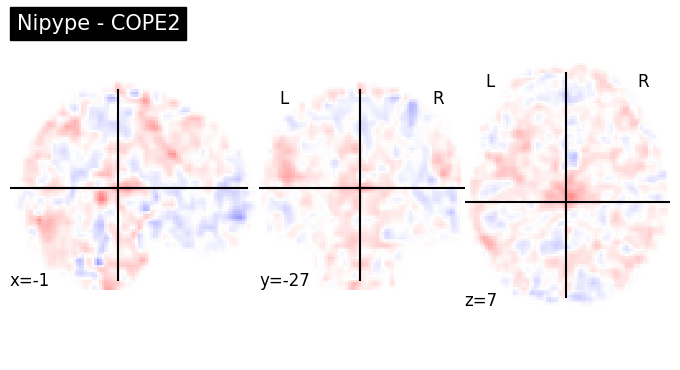

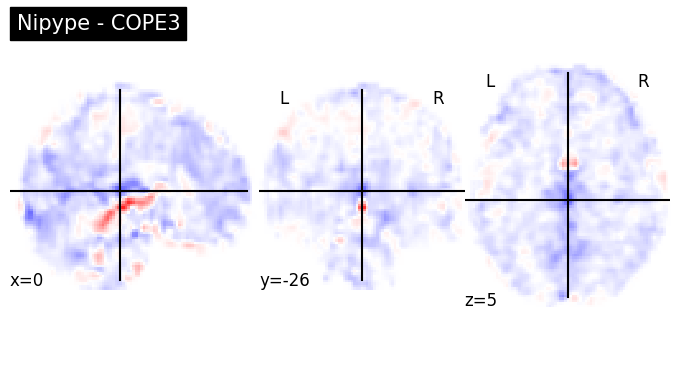

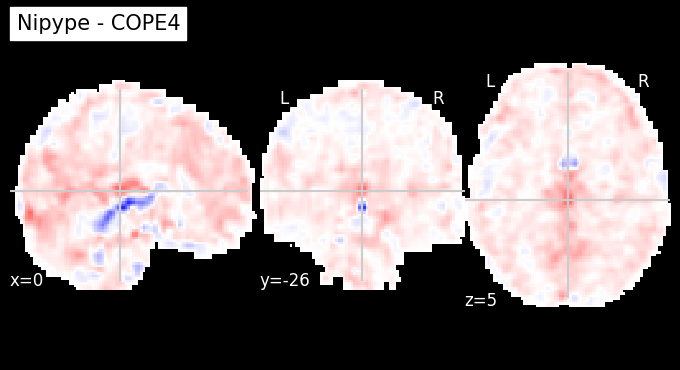

In [59]:
plotting.plot_stat_map(nipype_cope1, bg_img=nipype_cope1, title = 'Nipype - COPE1', cmap = 'bwr', colorbar = False)
plotting.plot_stat_map(nipype_cope2, bg_img=nipype_cope2, title = 'Nipype - COPE2', cmap = 'bwr', colorbar = False)
plotting.plot_stat_map(nipype_cope3, bg_img=nipype_cope3, title = 'Nipype - COPE3', cmap = 'bwr', colorbar = False)
plotting.plot_stat_map(nipype_cope4, bg_img=nipype_cope4, title = 'Nipype - COPE4', cmap = 'bwr', colorbar = False)
plt.show()

### Copes from the second-level GLM

Copes from subject-01:

In [60]:
nipype_cope1 = './output_level2/level2_results/contrast_1/stats_dir/_contr_id_1/stats/cope1.nii.gz'
nipype_cope2 = './output_level2/level2_results/contrast_2/stats_dir/_contr_id_2/stats/cope1.nii.gz'
nipype_cope3 = './output_level2/level2_results/contrast_3/stats_dir/_contr_id_3/stats/cope1.nii.gz'
nipype_cope4 = './output_level2/level2_results/contrast_4/stats_dir/_contr_id_4/stats/cope1.nii.gz'

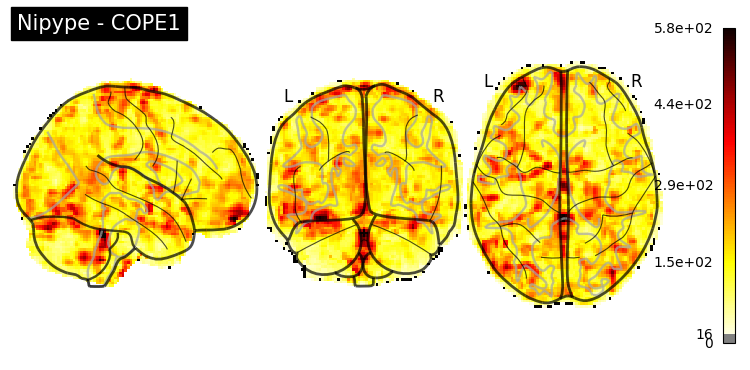

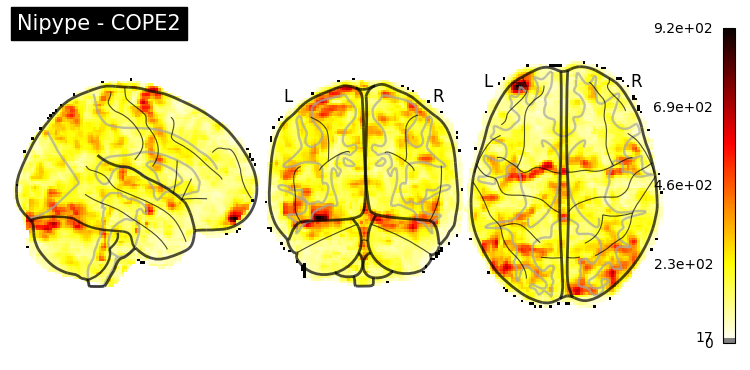

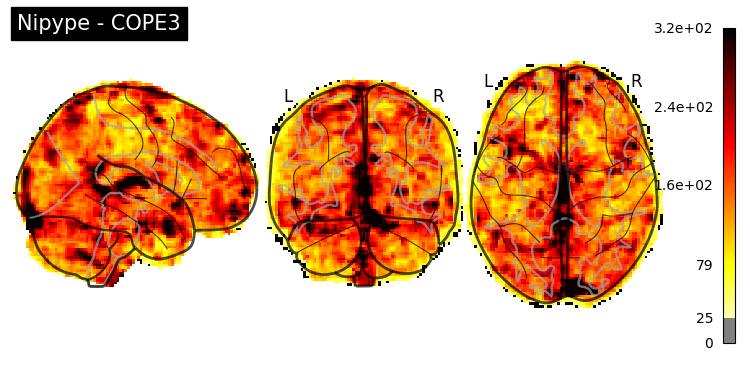

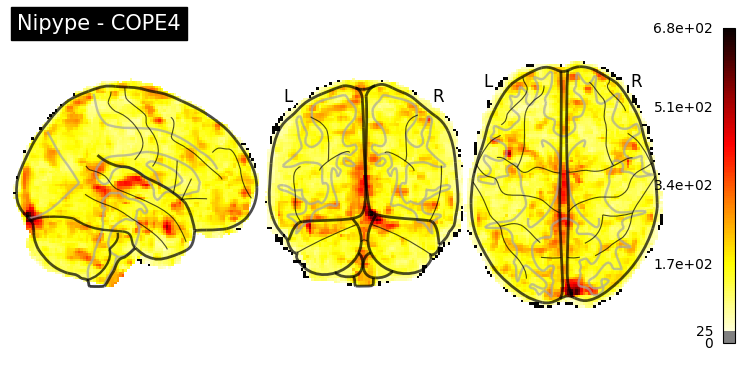

In [61]:
plotting.plot_glass_brain(nipype_cope1, bg_img=nipype_cope1, title = 'Nipype - COPE1')
plotting.plot_glass_brain(nipype_cope2, bg_img=nipype_cope2, title = 'Nipype - COPE2')
plotting.plot_glass_brain(nipype_cope3, bg_img=nipype_cope3, title = 'Nipype - COPE3')
plotting.plot_glass_brain(nipype_cope4, bg_img=nipype_cope4, title = 'Nipype - COPE4')
plt.show()

# Third-level GLM using Nipype FSL

Start the workflow

In [62]:
wf_third = pe.Workflow(name='level3', base_dir=exp_dir_third)
wf_third.config["execution"]["crashfile_format"] = "txt"

The following two nodes (`infosource` & `dg`) together define all inputs required for the preprocessing workflow

In [63]:
# we want to group the outcome by contrast not subject
contr_list = [1,2,3,4]
infosource_third = pe.Node(util.IdentityInterface(fields=["contr_id"]),
                  name="infosource_third")
infosource_third.iterables = [("contr_id", contr_list)]

In [64]:
# here we use SelectFiles, instead of DataGrabber, because the former is more flexible with formatting syntax
templates_third = {
    "copes":"contrast_{contr_id}/*/_contr_id_{contr_id}/*/cope*.nii.gz",
    "varcopes":"contrast_{contr_id}/*/_contr_id_{contr_id}/*/varcope*.nii.gz",
    "masks":"contrast_{contr_id}/*/_contr_id_{contr_id}/*/mask.nii.gz"
}
templates = {
    "reg_copes":"*/reg_copes/*/*/cope{contr_id}_flirt.nii.gz",
    "reg_varcopes":"*/reg_varcopes/*/*/varcope{contr_id}_flirt.nii.gz",
    "reg_masks":"*/reg_masks/*/*/*.nii.gz"
}

dg_third = pe.Node(interface=nio.SelectFiles(templates_third),
             name="selectfiles_third")
dg_third.inputs.base_directory = data_dir_third

wf_third.connect([
        (infosource_third, dg_third, [("contr_id", "contr_id")])
])

## Third-level GLM

Combining results from multiple runs of one subject into one

### Higher-level input files preparation
#### Step 1: Merge registered copes & varcopes & masks
**Corresponding FSL command:**
```
/usr/local/fsl/bin/fslmerge -t mask (masks from all 26 inputs)
/usr/local/fsl/bin/fslmerge -t cope (copes from all 26 inputs)
/usr/local/fsl/bin/fslmerge -t varcop (varcopes from all 26 inputs)
```

In [65]:
copemerge_third = pe.Node(
    interface=fsl.Merge(dimension='t'),
    iterfield=['in_files'],
    name="copemerge_third")

varcopemerge_third = pe.Node(
    interface=fsl.Merge(dimension='t'),
    iterfield=['in_files'],
    name="varcopemerge_third")

maskmerge_third = pe.Node(
    interface=fsl.Merge(dimension='t'),
    iterfield=['in_files'],
    name="maskmerge_third")

def repeat_mask(file):
    import numpy as np
    import glob
    # n_sub = len(glob.glob(os.path.join(os.getcwd(), 'ds000102')+"/sub-0*"))    
    n_sub = 9
    mask_lst = [file]
    repeated = np.repeat(mask_lst,n_sub)
    return list(repeated)

wf_third.connect(dg_third, 'copes', copemerge_third, 'in_files')
wf_third.connect(dg_third, 'varcopes', varcopemerge_third, 'in_files')
wf_third.connect(dg_third, ('masks', repeat_mask), maskmerge_third, 'in_files')

#### Step 2: Making mask

In FSL, there are many commands about `maskunique`, which is unless for the second level. We can ignore it.

**Corresponding FSL command:**
```
/usr/local/fsl/bin/fslmaths mask -Tmin mask
```

In [66]:
# /usr/local/fsl/bin/fslmaths mask -Tmin mask
minmask_third = pe.Node(
    interface=fsl.ImageMaths(op_string='-Tmin'),
    iterfield=['in_file'],
    name='minmask_third')

wf_third.connect(maskmerge_third, 'merged_file', minmask_third, 'in_file')

#### Step 3: Masking copes & varcopes

**Corresponding FSL command:**

we have four contrasts so the following commands repeat four times

```
/usr/local/fsl/bin/fslmaths cope1 -mas mask cope1
/usr/local/fsl/bin/fslmaths varcope1 -mas mask varcope1
```

In [67]:
maskcope_third = pe.Node(
    interface=fsl.ImageMaths(op_string='-mas'),
    iterfield=['in_file', 'in_file2'],
    name='maskcope_third')

maskvarcope_third = pe.Node(
    interface=fsl.ImageMaths(op_string='-mas'),
    iterfield=['in_file', 'in_file2'],
    name='maskvarcope_third')

wf_third.connect(copemerge_third, 'merged_file', maskcope_third, 'in_file')
wf_third.connect(minmask_third, 'out_file', maskcope_third, 'in_file2')
wf_third.connect(varcopemerge_third, 'merged_file', maskvarcope_third, 'in_file')
wf_third.connect(minmask_third, 'out_file', maskvarcope_third, 'in_file2')

### Set up third-level contrasts
Since we only have a single-group set-up, we can actually use [L2Model](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.model.html#l2model).
If we have an ANOVA-like design, using [MultipleRegressDesign](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.model.html#multipleregressdesign) would be a better option.

In [68]:
def num_copes(files):
    return len(files)

level3model = pe.Node(interface=fsl.L2Model(), name='l3model')
wf_third.connect(dg_third, ('copes',num_copes), level3model, 'num_copes')

In [69]:
level3estimate = pe.Node(
    interface=fsl.FLAMEO(run_mode='flame1'),
    name="level3estimate",
    iterfield=['cope_file', 'var_cope_file'])

wf_third.connect([
    (maskcope_third, level3estimate, [('out_file', 'cope_file')]),
    (maskvarcope_third, level3estimate, [('out_file', 'var_cope_file')]),
    (minmask_third, level3estimate, [('out_file', 'mask_file')]),
    (level3model, level3estimate, [('design_mat', 'design_file'),
                                   ('design_con', 't_con_file'), 
                                   ('design_grp', 'cov_split_file')]),
])

### Post-Stats
#### Smoothness estimation
to get `dlh` and `volume` for thresholding
**Corresponding FSL command:**
```
/usr/local/fsl/bin/smoothest -d 25 -m mask -r stats/res4d > stats/smoothness
```

In [70]:
smoothest = pe.Node(
    interface=fsl.SmoothEstimate(dof=25),
    name="smoothest",
    iterfield=['residual_fit_file', 'mask_file'])

wf_third.connect(minmask_third, 'out_file', smoothest, 'mask_file')
wf_third.connect(level3estimate, 'res4d', smoothest, 'residual_fit_file')

#### Mask zstats file

preparation for thresholding

**Corresponding FSL command:**

```
/usr/local/fsl/bin/fslmaths stats/zstat1 -mas mask thresh_zstat1
```

In [71]:
level3mask = pe.Node(
    interface=fsl.ImageMaths(op_string='-mas'),
    iterfield=['in_file','in_file2'],
    name='level3mask')

wf_third.connect([
    (level3estimate,level3mask,[('zstats', 'in_file')]),
    (minmask_third, level3mask, [('out_file', 'in_file2')]),
])

#### Cluster-wise thresholding

**Corresponding FSL command:**

```
/usr/local/fsl/bin/cluster -i thresh_zstat1 -t 3.1 --othresh=thresh_zstat1 -o cluster_mask_zstat1 --connectivity=26 --mm --olmax=lmax_zstat1_std.txt --scalarname=Z -p 0.05 -d 0.0595781 --volume=254734 -c stats/cope1 > cluster_zstat1_std.txt
```

In [72]:
level3threshold = pe.Node(
        interface=fsl.Cluster(threshold = 3.1,
                              pthreshold = 0.05,
                              use_mm = True,
                              out_threshold_file =True,
                              out_index_file = True,
                              out_localmax_txt_file = True),
    iterfield=['in_file','cope_file'],
    name='level3threshold')



wf_third.connect([
    (level3mask, level3threshold, [('out_file', 'in_file')]),
    (level3estimate, level3threshold, [('copes', 'cope_file')]),
    (smoothest, level3threshold, [('dlh', 'dlh'),
                                   ('volume', 'volume')]),
])

## Save the output

In [73]:
datasink_third = pe.Node(nio.DataSink(), name='sinker')
datasink_third.inputs.base_directory=os.path.join(exp_dir_third, "level3_results")

int2string = lambda x: 'contrast_'+str(x)
    
wf_third.connect(infosource_third, ('contr_id',int2string), datasink_third, 'container')
wf_third.connect([
    (level3estimate, datasink_third, [('stats_dir', 'stats_dir')]),
    (level3threshold, datasink_third, [('threshold_file', 'thresholded'),
                                ('localmax_txt_file', 'localmax_txt'),
                                ('index_file', 'index')]),
           ])

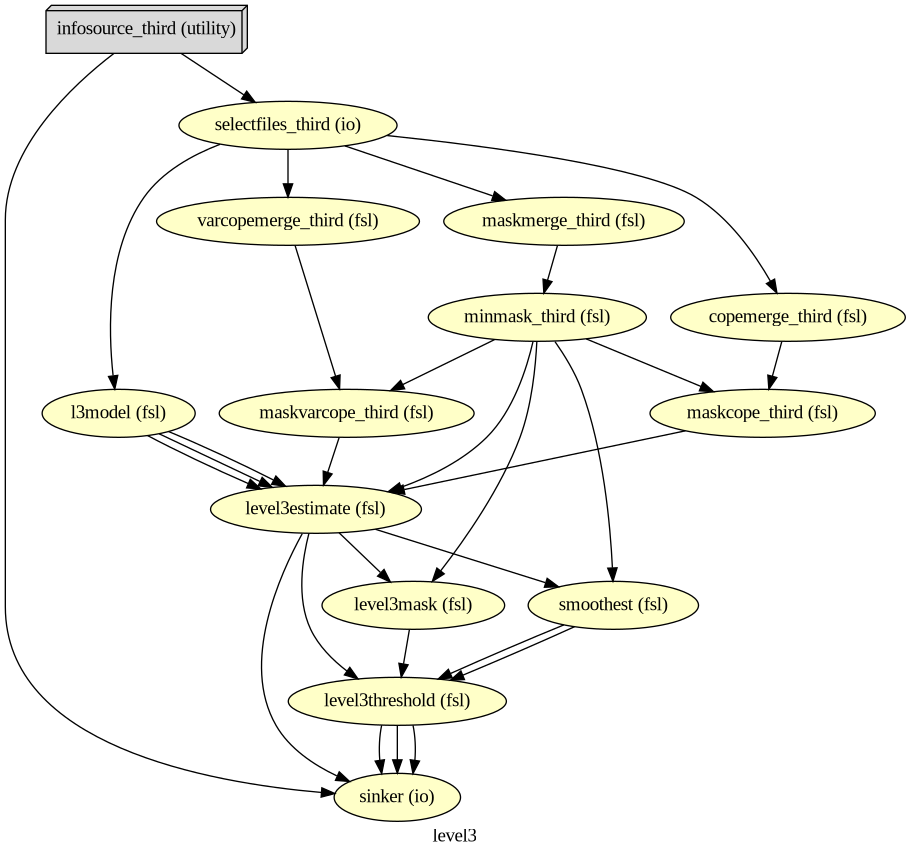

In [74]:
# Create 1st-level analysis output graph
wf_third.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=os.path.join(wf_third.base_dir, wf_third.name, 'graph.png'))

In [75]:
# Run Workflow
logging.getLogger('nipype.workflow').setLevel(0) 
wf_third.run(plugin="MultiProc", plugin_args={"n_procs": 8})

## Unthresholded COPEs

In [76]:
nipype_cope1 = './output_level3/level3_results/contrast_1/stats_dir/_contr_id_1/stats/cope1.nii.gz'
nipype_cope2 = './output_level3/level3_results/contrast_2/stats_dir/_contr_id_2/stats/cope1.nii.gz'
nipype_cope3 = './output_level3/level3_results/contrast_3/stats_dir/_contr_id_3/stats/cope1.nii.gz'
nipype_cope4 = './output_level3/level3_results/contrast_4/stats_dir/_contr_id_4/stats/cope1.nii.gz'

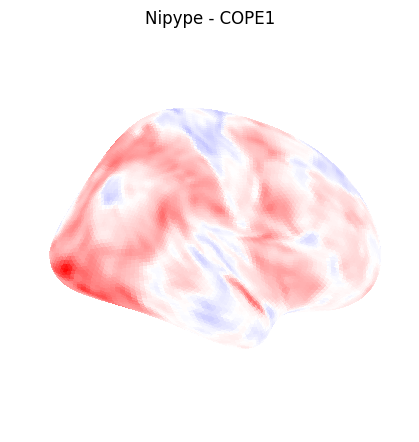

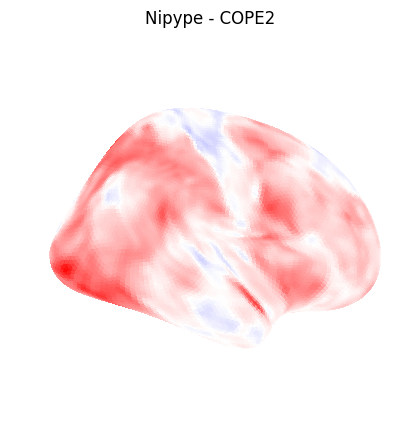

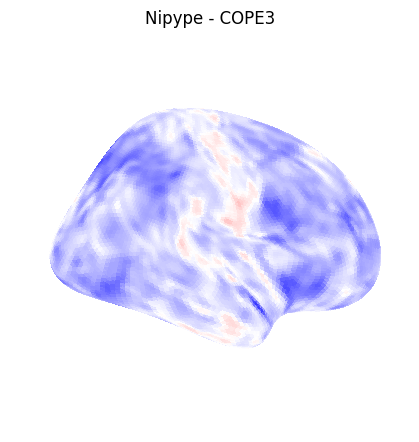

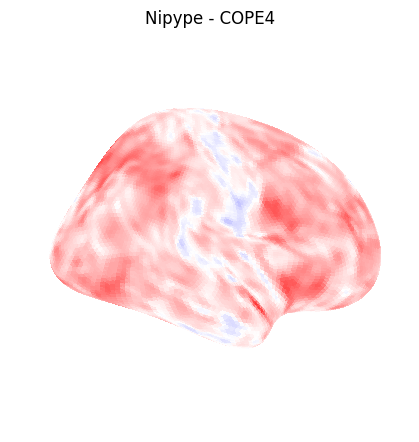

In [77]:
t_nipype_cope1 = surface.vol_to_surf(nipype_cope1, fsaverage.pial_right)
plotting.plot_surf_stat_map(
        fsaverage.infl_right, t_nipype_cope1, hemi='right',
        title="Nipype - COPE1", colorbar=False,
        cmap = 'bwr', bg_map=fsaverage.sulc_right)
plt.show()


t_nipype_cope2 = surface.vol_to_surf(nipype_cope2, fsaverage.pial_right)
plotting.plot_surf_stat_map(
        fsaverage.infl_right, t_nipype_cope2, hemi='right',
        title="Nipype - COPE2", colorbar=False,
        cmap = 'bwr', bg_map=fsaverage.sulc_right)
plt.show()


t_nipype_cope3 = surface.vol_to_surf(nipype_cope3, fsaverage.pial_right)
plotting.plot_surf_stat_map(
        fsaverage.infl_right, t_nipype_cope3, hemi='right',
        title="Nipype - COPE3", colorbar=False,
        cmap = 'bwr', bg_map=fsaverage.sulc_right)
plt.show()


t_nipype_cope4 = surface.vol_to_surf(nipype_cope4, fsaverage.pial_right)
plotting.plot_surf_stat_map(
        fsaverage.infl_right, t_nipype_cope4, hemi='right',
        title="Nipype - COPE4", colorbar=False,
        cmap = 'bwr', bg_map=fsaverage.sulc_right)
plt.show()

### Thresholded (p < 0.05) zstats

In [78]:
nipype_cope1 = './output_level3/level3_results/contrast_1/thresholded/_contr_id_1/zstat1_maths_threshold.nii.gz'
nipype_cope2 = './output_level3/level3_results/contrast_2/thresholded/_contr_id_2/zstat1_maths_threshold.nii.gz'
nipype_cope3 = './output_level3/level3_results/contrast_3/thresholded/_contr_id_3/zstat1_maths_threshold.nii.gz'
nipype_cope4 = './output_level3/level3_results/contrast_4/thresholded/_contr_id_4/zstat1_maths_threshold.nii.gz'

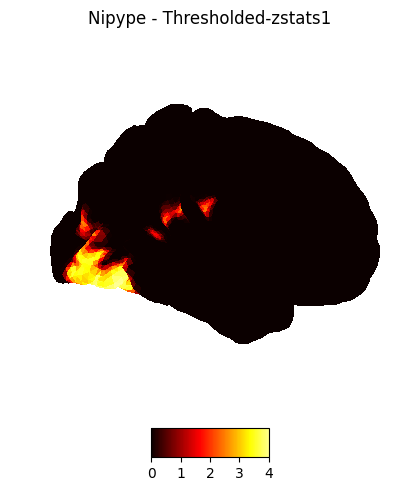

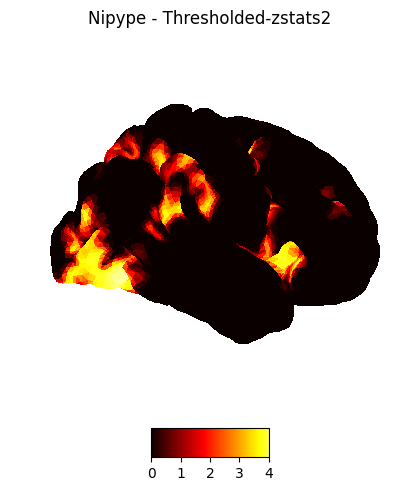

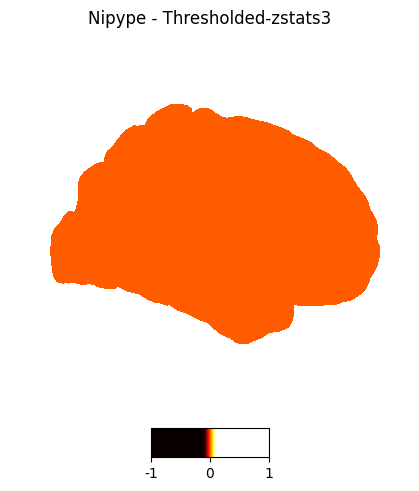

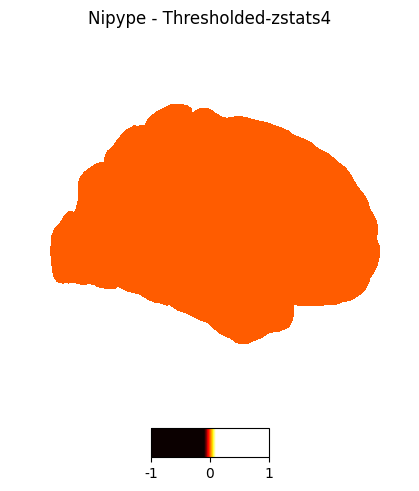

In [79]:
plotting.plot_img_on_surf(nipype_cope1,
                          views=['lateral'],
                          hemispheres=['right'],
                          title="Nipype - Thresholded-zstats1",
                          cmap = 'hot', colorbar=True)
plotting.show()

plotting.plot_img_on_surf(nipype_cope2,
                          views=['lateral'],
                          hemispheres=['right'],
                          title="Nipype - Thresholded-zstats2",
                          cmap = 'hot', colorbar=True)
plotting.show()

plotting.plot_img_on_surf(nipype_cope3,
                          views=['lateral'],
                          hemispheres=['right'],
                          title="Nipype - Thresholded-zstats3",
                          cmap = 'hot', colorbar=True)
plotting.show()

plotting.plot_img_on_surf(nipype_cope4,
                          views=['lateral'],
                          hemispheres=['right'],
                          title="Nipype - Thresholded-zstats4",
                          cmap = 'hot', colorbar=True)
plotting.show()

#### Dependencies in Jupyter/Python
- Using the package [watermark](https://github.com/rasbt/watermark) to document system environment and software versions used in this notebook

In [80]:
%load_ext watermark

%watermark
%watermark --iversions

Last updated: 2026-02-16T01:08:19.386886+00:00

Python implementation: CPython
Python version       : 3.13.9
IPython version      : 9.7.0

Compiler    : GCC 14.3.0
OS          : Linux
Release     : 5.15.0-164-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

IPython   : 9.7.0
logging   : 0.5.1.2
matplotlib: 3.10.8
nibabel   : 5.3.3
nilearn   : 0.13.1
nipype    : 1.10.0

